<a href="https://colab.research.google.com/github/najouaelfethi/bigdataproject/blob/main/EDA_Pr%C3%A9traitement%26Mod%C3%A9lisation_Pr%C3%A9dective_Consommation_%C3%A9nergitique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédire la consommation énergitique future (Analyse en séries temporelles)

## EDA (Exploratory Data Analysis)
**Objectif :** se mettre à l’aise avec le dataset et comprendre au maximum nos différentes variables pour ensuite définir une stratégie de modélisation. Qu’est-ce qu’on va faire avec nos données pour atteindre notre objectif ?
Checklist de base (Non-exhaustive) :

**Analyse de la forme :**
- **Identification de la Target :**
    - AEP_MW (consommation de l'énergie électrique en MégaWT)
- **Nombre de lignes et de colonnes :**(121273 Lignes, 2 Colonnes)
- **Types de variables :**
    - 1 Quantitative / Continue(AEP_MW)
    - 1 Qualitative / Variable temporelle (Datetime)
- **Analyse des valeurs manquantes :**
    - 0 valeurs manquantes trouvé.

**Analyse du fond :**
- **Visualisation de la Target :**
    - En déchiffrant la variable AWP_MW pour différent référence temporelle, nous obtenons qu'il y a certain année notamment **2004** et **2018** qui ne possèdent pas de valeurs de consommation pour certain mois.
    - Après une étude approfondie, nous avons conclu que ce sont les successivement les années de début et de fin de l'opération de collection des données de consommation énergitique.
- **Compréhension des différentes variables (Internet) :**
    - **Saisonalité -**
    - pendant les mois d'Hiver la consommation atteint ses pics notamment les mois 12-1-2, cela peut etre expliqué par le fait d'utilisation des chauffages. Ainsi que pendant l'été pour les climatiseurs.
    - En printemps et en automne, généralement ce sont des saisons stable en consommation, les moyennes de consommation sont plus faibles 3-4-5

    - **Mensualité -**
    - Apparemment que l'année 2007 préconise le pic de consommation, cela peut etre signifié par une crise énergitique mais cela reste qu'une hypothèse (à vérifier plus tard).
    - 2008 aussi reste importante en terme de consommation par rapport au autres distributions.
    - **Données Anuelle -**
    - la consommation depuis 2005 jusqu'à 2010 atteint ces pics, cepandant après 2010 la consommation continue à diminuer d'une façon plus vite.
    - Cela probablement est du à l'exploration de nouveaux sources d'enérgies remplacante, tels que les énergies renouvelables (solaire, éoliène, etc) ainsi que l'adoption de technologies plus économes en énergie dans les secteurs résidentiel, industriel et commercial.
    - **Données journalières -** ils sont apperement continues et ne contiennent pas de doublons.


- **Visualisation des relations Features – Target (Histogrammes/Boxplot) :**

- **Identification des outliers :**
    - Valeurs aberrantes détectées :  11



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/AEP_hourly.csv")

In [ ]:
data.head(25)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


In [ ]:
data.shape

(121273, 2)

In [ ]:
data.dtypes

,0
Datetime,object
AEP_MW,float64


# Visualisation des valeurs manquantes(NaN)

<Axes: >

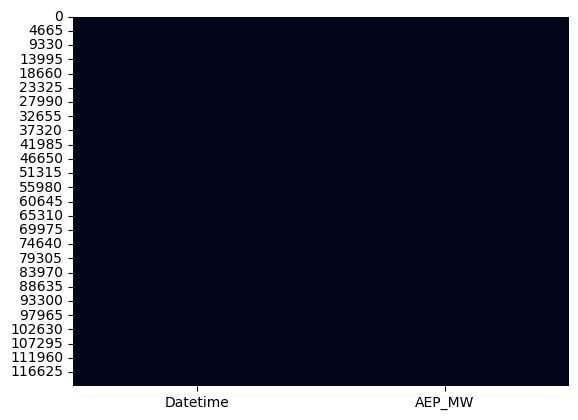

In [ ]:
sns.heatmap(data.isna(), cbar=False)

# Distribution de la consommation

<ipython-input-9-c436b7c09ded>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['AEP_MW'],shade=True, color="blue")


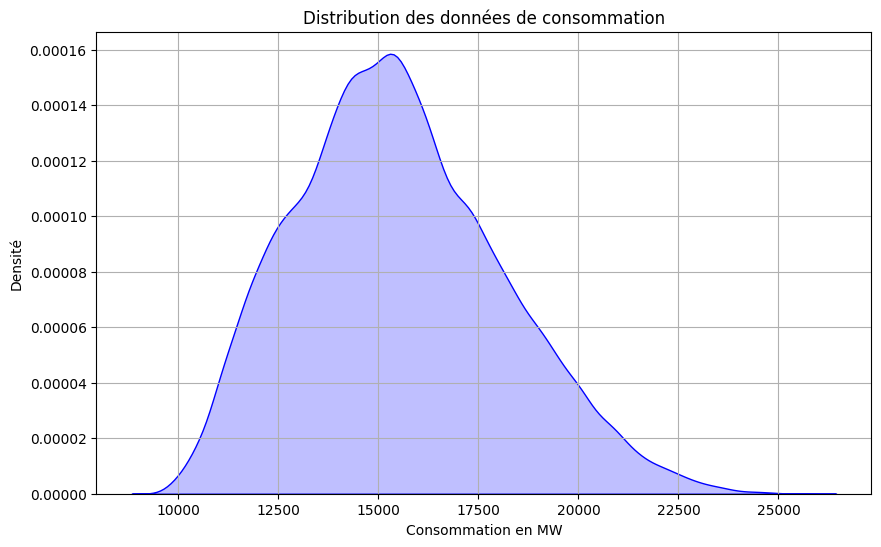

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data['AEP_MW'],shade=True, color="blue")
plt.title('Distribution des données de consommation')
plt.xlabel('Consommation en MW')
plt.ylabel('Densité')
plt.grid()
plt.show()

- les données de consommation suivent une distribution normale cela signifie qu'il n y a pas d'agitation démarquante dans nos données

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, year, month, avg, sum, to_date,col

In [5]:
spark = SparkSession.builder.appName("EnergyConsumptionApp").getOrCreate()

In [6]:
df = spark.read.csv("/content/drive/MyDrive/Datasets/AEP_hourly.csv", header=True, inferSchema=True)

df.printSchema()

df = df.withColumn("Datetime", to_timestamp(df["Datetime"]))

root
 |-- Datetime: timestamp (nullable = true)
 |-- AEP_MW: double (nullable = true)



In [7]:
df.show()

+-------------------+-------+
|           Datetime| AEP_MW|
+-------------------+-------+
|2004-12-31 01:00:00|13478.0|
|2004-12-31 02:00:00|12865.0|
|2004-12-31 03:00:00|12577.0|
|2004-12-31 04:00:00|12517.0|
|2004-12-31 05:00:00|12670.0|
|2004-12-31 06:00:00|13038.0|
|2004-12-31 07:00:00|13692.0|
|2004-12-31 08:00:00|14297.0|
|2004-12-31 09:00:00|14719.0|
|2004-12-31 10:00:00|14941.0|
|2004-12-31 11:00:00|15184.0|
|2004-12-31 12:00:00|15009.0|
|2004-12-31 13:00:00|14808.0|
|2004-12-31 14:00:00|14522.0|
|2004-12-31 15:00:00|14349.0|
|2004-12-31 16:00:00|14107.0|
|2004-12-31 17:00:00|14410.0|
|2004-12-31 18:00:00|15174.0|
|2004-12-31 19:00:00|15261.0|
|2004-12-31 20:00:00|14774.0|
+-------------------+-------+
only showing top 20 rows



#Extraction des variables Year & Month


In [8]:
df = df.withColumn("Year", year(df["Datetime"]))
df = df.withColumn("Month", month(df["Datetime"]))

In [9]:
df.show()

+-------------------+-------+----+-----+
|           Datetime| AEP_MW|Year|Month|
+-------------------+-------+----+-----+
|2004-12-31 01:00:00|13478.0|2004|   12|
|2004-12-31 02:00:00|12865.0|2004|   12|
|2004-12-31 03:00:00|12577.0|2004|   12|
|2004-12-31 04:00:00|12517.0|2004|   12|
|2004-12-31 05:00:00|12670.0|2004|   12|
|2004-12-31 06:00:00|13038.0|2004|   12|
|2004-12-31 07:00:00|13692.0|2004|   12|
|2004-12-31 08:00:00|14297.0|2004|   12|
|2004-12-31 09:00:00|14719.0|2004|   12|
|2004-12-31 10:00:00|14941.0|2004|   12|
|2004-12-31 11:00:00|15184.0|2004|   12|
|2004-12-31 12:00:00|15009.0|2004|   12|
|2004-12-31 13:00:00|14808.0|2004|   12|
|2004-12-31 14:00:00|14522.0|2004|   12|
|2004-12-31 15:00:00|14349.0|2004|   12|
|2004-12-31 16:00:00|14107.0|2004|   12|
|2004-12-31 17:00:00|14410.0|2004|   12|
|2004-12-31 18:00:00|15174.0|2004|   12|
|2004-12-31 19:00:00|15261.0|2004|   12|
|2004-12-31 20:00:00|14774.0|2004|   12|
+-------------------+-------+----+-----+
only showing top

# Visulaisation de la consommation moyenne par année

In [10]:
# Calculer la consommation moyenne par année
annual_avg_consumption = df.groupBy("Year").agg(avg("AEP_MW").alias("average_consumption"))

# Transformation en Pandas dataframe
pd_annual_avg_consumption = annual_avg_consumption.toPandas()

# Sauvegarde des résultats
pd_annual_avg_consumption.to_excel("/content/drive/MyDrive/Datasets/result_data/AVG_annee.xlsx",index=False)

# Afficher les résultats
annual_avg_consumption.show()

+----+-------------------+
|Year|average_consumption|
+----+-------------------+
|2007|  16645.51929664307|
|2018| 15290.612733644859|
|2015| 14868.922602739725|
|2006| 15737.224252112355|
|2013| 15198.211577985841|
|2014|  15169.07889028428|
|2004| 15176.724388032639|
|2012|  15352.94066734996|
|2009| 15254.111669330898|
|2016| 14784.225979052824|
|2005| 15842.990865494405|
|2010| 16008.619504396484|
|2011| 15815.389472482302|
|2008|  16536.65565930312|
|2017| 14483.738356164384|
+----+-------------------+



In [11]:
# Filtrage des années en ordre
pd_annual_avg_consumption = pd_annual_avg_consumption.sort_values('Year')

# Affichage du dataframe
pd_annual_avg_consumption

,Year,average_consumption
6,2004,15176.724388
10,2005,15842.990865
3,2006,15737.224252
0,2007,16645.519297
13,2008,16536.655659
8,2009,15254.111669
11,2010,16008.619504
12,2011,15815.389472
7,2012,15352.940667
4,2013,15198.211578


#Visualisation de la consommation annuelle


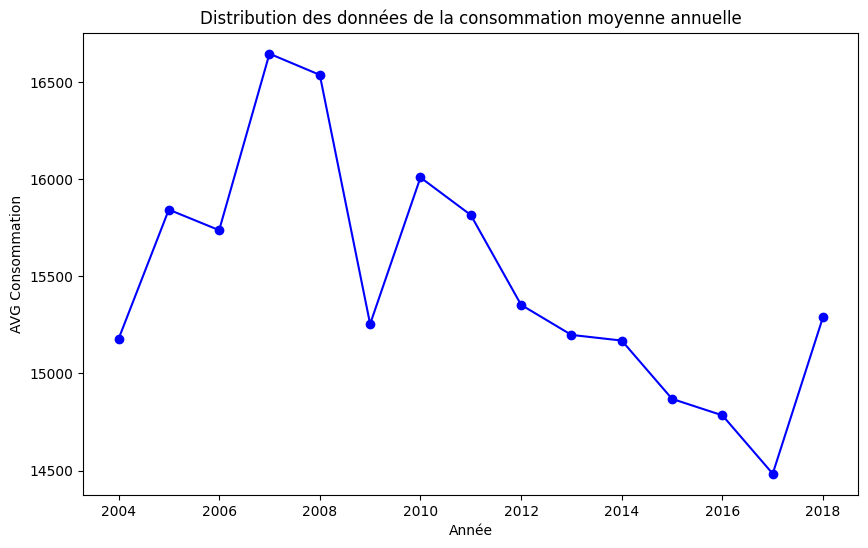

In [12]:
plt.figure(figsize=(10,6))
plt.plot(pd_annual_avg_consumption['Year'],pd_annual_avg_consumption['average_consumption'], marker='o', color="blue")
plt.title('Distribution des données de la consommation moyenne annuelle')
plt.xlabel('Année')
plt.ylabel('AVG Consommation')
plt.show()

- la consommation depuis 2005 jusqu'à 2010 atteint ces pics, cepandant après 2010 la consommation continue à diminuer d'une façon plus vite.
- Cela probablement est du à l'exploration de nouveaux sources d'enérgies remplacante, tels que les énergies renouvelables (solaire, éoliène, etc) ainsi que l'adoption de technologies plus économes en énergie dans les secteurs résidentiel, industriel et commercial.

# Visualisation de la consommation mensuelle pour chaque année

In [13]:
# Agréger les données par année et mois
df_monthly_consumption = df.groupBy("Year", "Month") \
    .agg(
        sum("AEP_MW").alias("total_consumption"),  # Somme de la consommation
        avg("AEP_MW").alias("avg_consumption")  # Moyenne de la consommation
    ) \
    .orderBy("Year","Month")  # Trier par année et mois

# Afficher le résultat
df_monthly_consumption.show()


+----+-----+-----------------+------------------+
|Year|Month|total_consumption|   avg_consumption|
+----+-----+-----------------+------------------+
|2004|   10|      1.0349073E7|13947.537735849057|
|2004|   11|      1.0677917E7|14830.440277777778|
|2004|   12|      1.2452864E7|16737.720430107525|
|2005|    1|      1.2735114E7| 17117.08870967742|
|2005|    2|      1.1085745E7|16496.644345238095|
|2005|    3|      1.1847502E7| 15924.06182795699|
|2005|    4|      1.0089312E7| 14032.42280945758|
|2005|    5|      1.0181694E7|13685.072580645161|
|2005|    6|       1.170024E7|16250.333333333334|
|2005|    7|      1.2546722E7| 16863.87365591398|
|2005|    8|      1.2834811E7| 17251.09005376344|
|2005|    9|      1.1049942E7|15347.141666666666|
|2005|   10|      1.0685367E7|14381.382234185734|
|2005|   11|      1.0940315E7|15194.881944444445|
|2005|   12|       1.305615E7| 17548.58870967742|
|2006|    1|      1.2208918E7|16409.836021505376|
|2006|    2|      1.1569171E7|17216.028273809523|


# Années incomplètes au niveau des mois

In [14]:
df_monthly_consumption.filter(df_monthly_consumption['Year']==2004).show()

+----+-----+-----------------+------------------+
|Year|Month|total_consumption|   avg_consumption|
+----+-----+-----------------+------------------+
|2004|   10|      1.0349073E7|13947.537735849057|
|2004|   11|      1.0677917E7|14830.440277777778|
|2004|   12|      1.2452864E7|16737.720430107525|
+----+-----+-----------------+------------------+



In [15]:
df_monthly_consumption.filter(df_monthly_consumption['Year']==2018).show()

+----+-----+-----------------+------------------+
|Year|Month|total_consumption|   avg_consumption|
+----+-----+-----------------+------------------+
|2018|    1|      1.3090587E7|         17594.875|
|2018|    2|      1.0265918E7| 15276.66369047619|
|2018|    3|      1.1228646E7|15112.578734858682|
|2018|    4|        9820256.0|13639.244444444445|
|2018|    5|      1.0503052E7|14117.005376344086|
|2018|    6|       1.101978E7|          15305.25|
|2018|    7|      1.1849407E7|15926.622311827958|
|2018|    8|         754941.0|15406.959183673469|
+----+-----+-----------------+------------------+



- 2004 ne possède que trois mois 10,11,12

- 2018 ne possède que entre 1-8



# Décision immédiate
- On a décidé d'éliminer ces deux année (2004 & 2018) bien que cela concerne la phase prétraitement

In [16]:
# Elimination des année non complètes en termes de mois
df = df.filter((df_monthly_consumption['Year']!=2004) & (df_monthly_consumption['Year']!=2018))

df_monthly_consumption = df_monthly_consumption.filter((df_monthly_consumption['Year']!=2004) & (df_monthly_consumption['Year']!=2018))

In [17]:
# Transformation en Pandas dataframe
pd_monthly_consumption = df_monthly_consumption.orderBy("Year", "Month").toPandas()

# Sauvegarde des résultats
pd_monthly_consumption.to_excel("/content/drive/MyDrive/Datasets/result_data/Consommation_mensuelle_par_annee.xlsx",index=False)

In [18]:
pd_monthly_consumption

,Year,Month,total_consumption,avg_consumption
0,2005,1,12735114.0,17117.088710
1,2005,2,11085745.0,16496.644345
2,2005,3,11847502.0,15924.061828
3,2005,4,10089312.0,14032.422809
4,2005,5,10181694.0,13685.072581
...,...,...,...,...
151,2017,8,11190134.0,15040.502688
152,2017,9,9945277.0,13812.884722
153,2017,10,9921554.0,13335.422043
154,2017,11,10305415.0,14293.224688


# Visualisation de la consommation mensuelle pour chaque année du Dataset

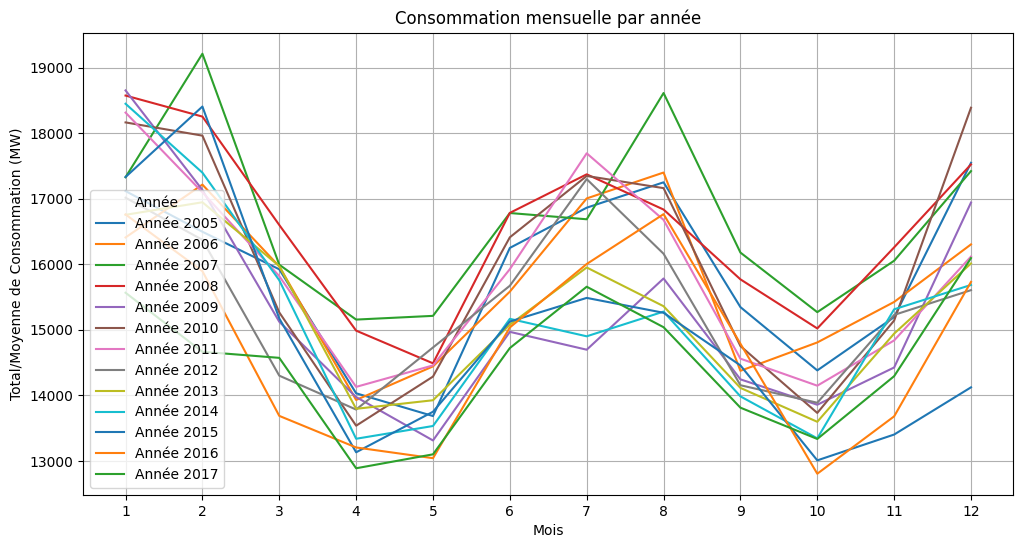

In [19]:
# Préparer les données pour le tracé
years = pd_monthly_consumption['Year'].unique()  # Liste des années disponibles

plt.figure(figsize=(12, 6))

# Boucle pour tracer une courbe par année
for year in years:
    # Filtrer les données pour une année donnée
    data_year = pd_monthly_consumption[pd_monthly_consumption['Year'] == year]
    # Tracer les données pour cette année
    plt.plot(
        data_year['Month'],
        data_year['avg_consumption'],  # Remplacez par 'avg_consumption' si nécessaire
        #marker='o',
        label=f"Année {year}"
    )

# Ajouter des labels et une légende
plt.title('Consommation mensuelle par année')
plt.xlabel('Mois')
plt.ylabel('Total/Moyenne de Consommation (MW)')
plt.xticks(range(1, 13))  # Afficher les mois de 1 à 12
plt.legend(title="Année")
plt.grid(True)
plt.show()


##Résultat & explications
- Apparemment que l'année 2007 préconise le pic de consommation, cela peut etre signifié par une crise énergitique mais cela reste qu'une hypothèse (à vérifier plus tard).
- 2008 aussi reste importante en terme de consommation par rapport au autres distributions.

# Visualisation de la consommation globale par saisons (Hiver, Printemps, été, Automne)

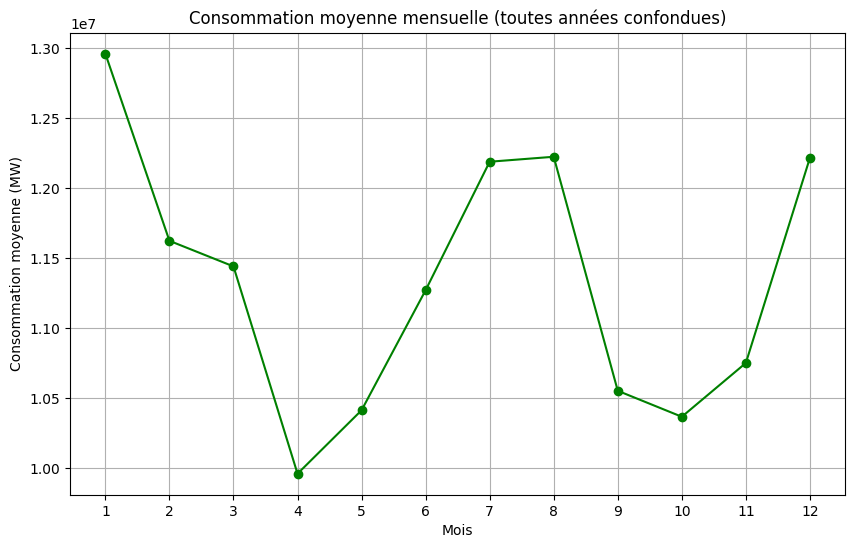

In [20]:
df_monthly_avg = df_monthly_consumption.groupBy("Month") \
    .agg(avg("total_consumption").alias("avg_monthly_consumption")) \
    .orderBy("Month").toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df_monthly_avg['Month'], df_monthly_avg['avg_monthly_consumption'], marker='o', color='green')
plt.title('Consommation moyenne mensuelle (toutes années confondues)')
plt.xlabel('Mois')
plt.ylabel('Consommation moyenne (MW)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


- pendant les mois d'Hiver la consommation atteint ses pics notamment les mois 12-1-2, cela peut etre expliqué par le fait d'utilisation des chauffages. Ainsi que pendant l'été pour les climatiseurs.

- En printemps et en automne, généralement ce sont des saisons stable en consommation, les moyennes de consommation sont plus faibles 3-4-5

# Consommation journalière

In [22]:
#df_without_04_18 = df.filter((df_monthly_consumption['Year']!=2004) & (df_monthly_consumption['Year']!=2018))

df_daily_consumption = df.withColumn("Date", to_date("Datetime"))

df_daily_sum = df_daily_consumption.groupBy("Date").agg(sum("AEP_MW").alias("Daily_Total_Consumption"))

pd_daily_sum = df_daily_sum.orderBy("Date").toPandas()


df_daily_sum.show()


+----------+-----------------------+
|      Date|Daily_Total_Consumption|
+----------+-----------------------+
|2005-06-06|               415076.0|
|2005-01-16|               400928.0|
|2006-05-21|               299369.0|
|2006-05-17|               350074.0|
|2007-11-23|               364940.0|
|2007-11-15|               405689.0|
|2007-04-20|               360528.0|
|2009-11-22|               336695.0|
|2009-07-25|               329883.0|
|2010-08-11|               463118.0|
|2012-10-06|               294810.0|
|2012-04-17|               336136.0|
|2013-09-09|               395840.0|
|2013-05-21|               392858.0|
|2013-03-26|               412198.0|
|2013-01-22|               487307.0|
|2014-11-12|               361410.0|
|2014-09-26|               331291.0|
|2015-05-19|               342909.0|
|2015-03-09|               361881.0|
+----------+-----------------------+
only showing top 20 rows



In [23]:
# Sauvegarde des résultats
pd_daily_sum.to_excel("/content/drive/MyDrive/Datasets/result_data/daily_data.xlsx",index=False)
pd_daily_sum

,Date,Daily_Total_Consumption
0,2005-01-01,311897.0
1,2005-01-02,322712.0
2,2005-01-03,363937.0
3,2005-01-04,374003.0
4,2005-01-05,389445.0
...,...,...
4743,2017-12-27,439663.0
4744,2017-12-28,465511.0
4745,2017-12-29,434221.0
4746,2017-12-30,414764.0


# Vérification des doublons

In [24]:
from pyspark.sql.functions import count

# Groupement par date et comptage
duplicates = df_daily_sum.groupBy("Date").agg(count("*").alias("count"))

# Filtrer les dates ayant plus d'une occurrence
duplicates = duplicates.filter(col("count") > 1)

# Afficher les doublons
duplicates.show()


+----+-----+
|Date|count|
+----+-----+
+----+-----+



#Vérification des outliers

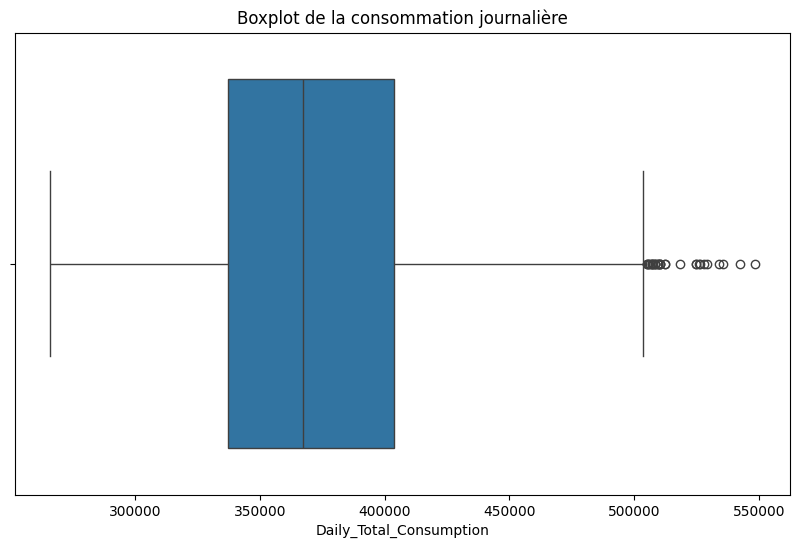

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd_daily_sum["Daily_Total_Consumption"])
plt.title("Boxplot de la consommation journalière")
plt.show()

In [26]:
from scipy.stats import zscore


pd_daily_sum["z_score"] = zscore(pd_daily_sum["Daily_Total_Consumption"])
outliers = pd_daily_sum[pd_daily_sum["z_score"].abs() > 3]
print("Valeurs aberrantes détectées : ", len(outliers))


Valeurs aberrantes détectées :  11


In [27]:
outliers

,Date,Daily_Total_Consumption,z_score
765,2007-02-05,526420.0,3.241733
766,2007-02-06,542682.0,3.583775
1476,2009-01-16,548349.0,3.702971
2173,2010-12-14,518482.0,3.074771
3293,2014-01-07,535660.0,3.436080
3310,2014-01-24,528058.0,3.276185
3314,2014-01-28,525861.0,3.229975
3315,2014-01-29,524931.0,3.210414
3659,2015-01-08,524960.0,3.211024
3701,2015-02-19,533988.0,3.400912


In [28]:
import numpy as np

np_outliers= outliers["Daily_Total_Consumption"].to_numpy()
np_outliers

array([526420., 542682., 548349., 518482., 535660., 528058., 525861.,
       524931., 524960., 533988., 529129.])

##Prétraitement des données (Features Engineering, Encodage, Standardisation, etc)
- **Objectif :** Préparation de nos données en format plus propice pour que notre modèle réussi à bien prévoire la consommation future
  

#Vérification de la linéarité des données

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


                              OLS Regression Results                              
Dep. Variable:     avg_annual_consumption   R-squared:                       0.653
Model:                                OLS   Adj. R-squared:                  0.621
Method:                     Least Squares   F-statistic:                     20.70
Date:                    Sun, 15 Dec 2024   Prob (F-statistic):           0.000831
Time:                            18:03:28   Log-Likelihood:                -181.05
No. Observations:                      13   AIC:                             366.1
Df Residuals:                          11   BIC:                             367.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

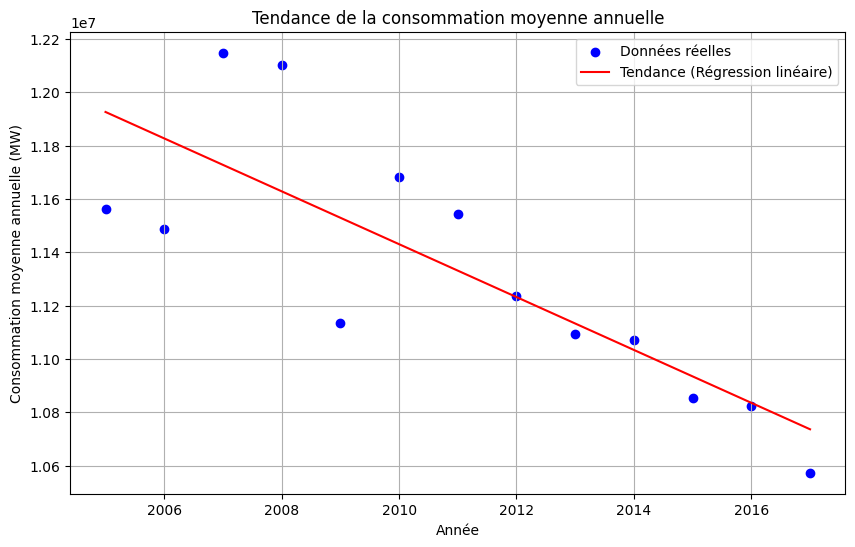

In [29]:
import statsmodels.api as sm

df_annual = df_monthly_consumption.groupBy("Year") \
    .agg(avg("total_consumption").alias("avg_annual_consumption")) \
    .orderBy("Year").toPandas()

X = df_annual['Year']
y = df_annual['avg_annual_consumption']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Tracé
plt.figure(figsize=(10, 6))
plt.scatter(df_annual['Year'], df_annual['avg_annual_consumption'], color='blue', label='Données réelles')
plt.plot(df_annual['Year'], model.predict(X), color='red', label='Tendance (Régression linéaire)')
plt.title('Tendance de la consommation moyenne annuelle')
plt.xlabel('Année')
plt.ylabel('Consommation moyenne annuelle (MW)')
plt.legend()
plt.grid(True)
plt.show()


###importation des données journalières

In [30]:
#df1 = pd.read_excel("/content/drive/MyDrive/Datasets/result_data/daily_data.xlsx")
df1 = df_daily_sum
df1.show()

+----------+-----------------------+
|      Date|Daily_Total_Consumption|
+----------+-----------------------+
|2005-06-06|               415076.0|
|2005-01-16|               400928.0|
|2006-05-21|               299369.0|
|2006-05-17|               350074.0|
|2007-11-23|               364940.0|
|2007-11-15|               405689.0|
|2007-04-20|               360528.0|
|2009-11-22|               336695.0|
|2009-07-25|               329883.0|
|2010-08-11|               463118.0|
|2012-10-06|               294810.0|
|2012-04-17|               336136.0|
|2013-09-09|               395840.0|
|2013-05-21|               392858.0|
|2013-03-26|               412198.0|
|2013-01-22|               487307.0|
|2014-11-12|               361410.0|
|2014-09-26|               331291.0|
|2015-05-19|               342909.0|
|2015-03-09|               361881.0|
+----------+-----------------------+
only showing top 20 rows



###Remplacement des valeurs aberrentes (outliers) avec la moyenne

In [31]:
#avg_value = df1["Daily_Total_Consumption"].mean()
#avg_value

#df1.loc[df["z_score"].abs() > 3, "Daily_Total_Consumption"] = avg_value


TypeError: 'Column' object is not callable

In [32]:
from pyspark.sql import functions as F
# Calculer la moyenne de la colonne Daily_Total_Consumption
mean_value = df1.select(F.mean("Daily_Total_Consumption")).collect()[0][0]
# Remplacer les valeurs aberrantes spécifiques par la moyenne
# définition des 11 outliers trouvé pendant l'EDA
detected_outliers = np_outliers.tolist()

# Remplacer ces valeurs par la moyenne
df1 = df1.withColumn("Daily_Total_Consumption",
                   F.when(F.col("Daily_Total_Consumption").isin(detected_outliers), mean_value)
                    .otherwise(F.col("Daily_Total_Consumption"))
                  )

#Vérifier le résultat
df1.show()

+----------+-----------------------+
|      Date|Daily_Total_Consumption|
+----------+-----------------------+
|2005-06-06|               415076.0|
|2005-01-16|               400928.0|
|2006-05-21|               299369.0|
|2006-05-17|               350074.0|
|2007-11-23|               364940.0|
|2007-11-15|               405689.0|
|2007-04-20|               360528.0|
|2009-11-22|               336695.0|
|2009-07-25|               329883.0|
|2010-08-11|               463118.0|
|2012-10-06|               294810.0|
|2012-04-17|               336136.0|
|2013-09-09|               395840.0|
|2013-05-21|               392858.0|
|2013-03-26|               412198.0|
|2013-01-22|               487307.0|
|2014-11-12|               361410.0|
|2014-09-26|               331291.0|
|2015-05-19|               342909.0|
|2015-03-09|               361881.0|
+----------+-----------------------+
only showing top 20 rows



In [34]:
#Vérification que les outliers correctement remplacés
from scipy.stats import zscore

df1_pd = df1.toPandas()

df1_pd["z_score"] = zscore(df1_pd["Daily_Total_Consumption"])
outliers = df1_pd[df1_pd["z_score"].abs() > 3]
print("Valeurs aberrantes détectées : ", len(outliers))

Valeurs aberrantes détectées :  0


#Features Enginnering
###Ajout de décalage temporelles (lags)

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Définir une fenêtre ordonnée par date
window_spec = Window.orderBy("date")

# Ajouter des lags (1 jour, 7 jours)
df = df.withColumn("lag_1", lag("Daily_Total_Consumption", 1).over(window_spec)) \
       .withColumn("lag_7", lag("Daily_Total_Consumption", 7).over(window_spec))

# Vérifier les données
df.show()


###moyennes mobiles (fenêtres glissantes)

In [ ]:
from pyspark.sql.functions import mean

# Fenêtre de 7 jours glissants (les 6 jours précédents + le jour actuel)
window_spec_7 = Window.orderBy("date").rowsBetween(-6, 0)

# Ajouter la moyenne mobile
df = df.withColumn("moving_avg_7", mean("Daily_Total_Consumption").over(window_spec_7))

# Vérifier les données
df.show()
